# Introduction

# Table of contents:

0. [Importing libraries](#lib)
1. [Data exploration and pre-processing](#eda)

  - [Profiling report of dataset](#pp)
  - [Text data visualization](#td)
  - [Text data pre-processing](#tdp)
2. [Modelling](#mod)
  - [Baseline model](#base)
  - [Hyperparameters tunning for LDA](#param)
  - [Second model](#final)
3. [Investigation on LDA results](#invest)
  - [Graphical representation](#graph)
4. [BERTopic model](#bert)
  - [Getting topics from BERTopic model and evaluation](#berteval)
  - [Visualizations](#viz)
  


# 0. Importing libraries

<a id="lib"></a>


In [3]:
!pip install -q spacy
!pip install -q bertopic
!pip install -q pyLDAvis
!python -m spacy download en_core_web_lg
import spacy.cli
spacy.cli.download("en_core_web_lg")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.7/400.7 MB 3.0 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.7/400.7 MB 2.7 MB/s eta 0:00:00


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [4]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pandas_profiling as pp
from markupsafe import escape
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import string
# model building imports
import gensim
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, LdaMulticore
from gensim.utils import simple_tokenize
from gensim.corpora import Dictionary
import time
import tqdm
from sklearn.feature_extraction.text import CountVectorizer
import pyLDAvis
import pickle
from pyLDAvis import gensim
from imp import reload
# BERTtopic imports
import gensim.corpora as corpora
import pandas as pd
import numpy as np
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.vectorizers import ClassTfidfTransformer
from sklearn.datasets import fetch_20newsgroups
from bertopic.representation import MaximalMarginalRelevance

os.environ["TOKENIZERS_PARALLELISM"] = 'false'

%matplotlib inline

# matplotlib defaults
plt.style.use("ggplot")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

import warnings 
warnings.filterwarnings('ignore')
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('punkt')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# 1. Data exploration and pre-processing

<a id="eda"></a>


In [5]:
df = pd.read_json('../input/news-category-dataset/News_Category_Dataset_v3.json', lines=True)
df.drop(df[df['category'] == 'QUEER VOICES'].index, inplace = True)
df = df.reset_index(drop=True)
df

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22
...,...,...,...,...,...,...
203175,https://www.huffingtonpost.com/entry/rim-ceo-t...,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,TECH,Verizon Wireless and AT&T are already promotin...,"Reuters, Reuters",2012-01-28
203176,https://www.huffingtonpost.com/entry/maria-sha...,Maria Sharapova Stunned By Victoria Azarenka I...,SPORTS,"Afterward, Azarenka, more effusive with the pr...",,2012-01-28
203177,https://www.huffingtonpost.com/entry/super-bow...,"Giants Over Patriots, Jets Over Colts Among M...",SPORTS,"Leading up to Super Bowl XLVI, the most talked...",,2012-01-28
203178,https://www.huffingtonpost.com/entry/aldon-smi...,Aldon Smith Arrested: 49ers Linebacker Busted ...,SPORTS,CORRECTION: An earlier version of this story i...,,2012-01-28


In [6]:
# shape of the dataset
print(df.shape)
# total number of unique categories
print("Unique categories:",df['category'].nunique())
print("-------------------------------------------------")
# information about metadata
df.info()

(203180, 6)
Unique categories: 41
-------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203180 entries, 0 to 203179
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   link               203180 non-null  object        
 1   headline           203180 non-null  object        
 2   category           203180 non-null  object        
 3   short_description  203180 non-null  object        
 4   authors            203180 non-null  object        
 5   date               203180 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 9.3+ MB


In [6]:
df.drop_duplicates(inplace=True)
df['short_description'] = df['short_description'].fillna('').astype(str)
df = df[df.short_description != '']
df = df.drop_duplicates(subset=['short_description'], keep=False)
df = df.reset_index(drop=True)

In [37]:
# general descrption of dataset
df.describe().style.set_properties(**{'background-color': '#F0F0F0',
                                    'color': '#222222',
                                    'border': '1.5px  solid black'})

,link,headline,category,short_description,authors,date
count,180740,180740,180740,180740,180740,180740
unique,180724,179805,41,180740,27181,3890
top,https://www.huffingtonpost.comhttps://www.washingtonpost.com/blogs/post-partisan/wp/2016/03/21/i-asked-trump-a-policy-question-then-he-called-me-beautiful/,Sunday Roundup,POLITICS,Health experts said it is too early to predict whether demand would match up with the 171 million doses of the new boosters the U.S. ordered for the fall.,,2012-11-26 00:00:00
freq,2,90,31872,1,31107,100
first,nan,nan,nan,nan,nan,2012-01-28 00:00:00
last,nan,nan,nan,nan,nan,2022-09-23 00:00:00


In [39]:
df.head()

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


## 1.1 Profiling report of dataset

<a id="pp"></a>


In [41]:
# produce pandas profiling report
df.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

**Key findings:**

1. Dataset has total **41** distinct categories of news articles
2. **'Politics'** is the most common category of news in our dataset. **Wellness** and **Entertainment** are taking 2nd and 3d places.
3. We have total of **27181** unique authors who have written various news articles
4. Dates of news starts from 2012-01-28 and goes up to 2022-09-23. 

## 1.2 Text data visualization

<a id="td"></a>


In [42]:
# drop columns like authors, links and date as they are irrelevent to our problem.
new_df = df.drop(columns=['authors','link'])
new_df.head()

,headline,category,short_description,date
0,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,2022-09-23
1,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,2022-09-23
2,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",2022-09-23
3,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",2022-09-23
4,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,2022-09-22


### 1.2.1 TOP 10 Categories of News Articles

In [44]:
# Top categories by and number of articles per categories
cat_df = pd.DataFrame(new_df['category'].value_counts()).reset_index()
cat_df.rename(columns={'index':'news_classes','category':'numcat'}, inplace=True)

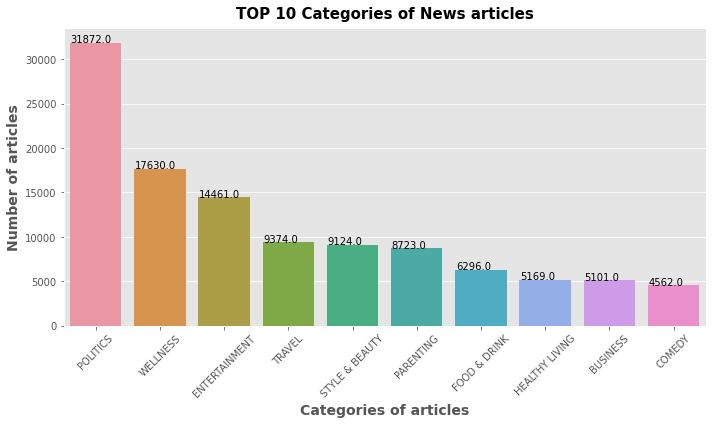

In [45]:
# Visualize top 10 categories and proportion of each categories in dataset
plt.figure(figsize=(10,6))
ax = sns.barplot(np.array(cat_df.news_classes)[:10], np.array(cat_df.numcat)[:10])
for p in ax.patches:
    ax.annotate(p.get_height(), (p.get_x()+0.01, p.get_height() + 50))
plt.title("TOP 10 Categories of News articles", size=15)
plt.xlabel("Categories of articles", size=14)
plt.xticks(rotation=45)
plt.ylabel("Number of articles", size=14)
plt.show()

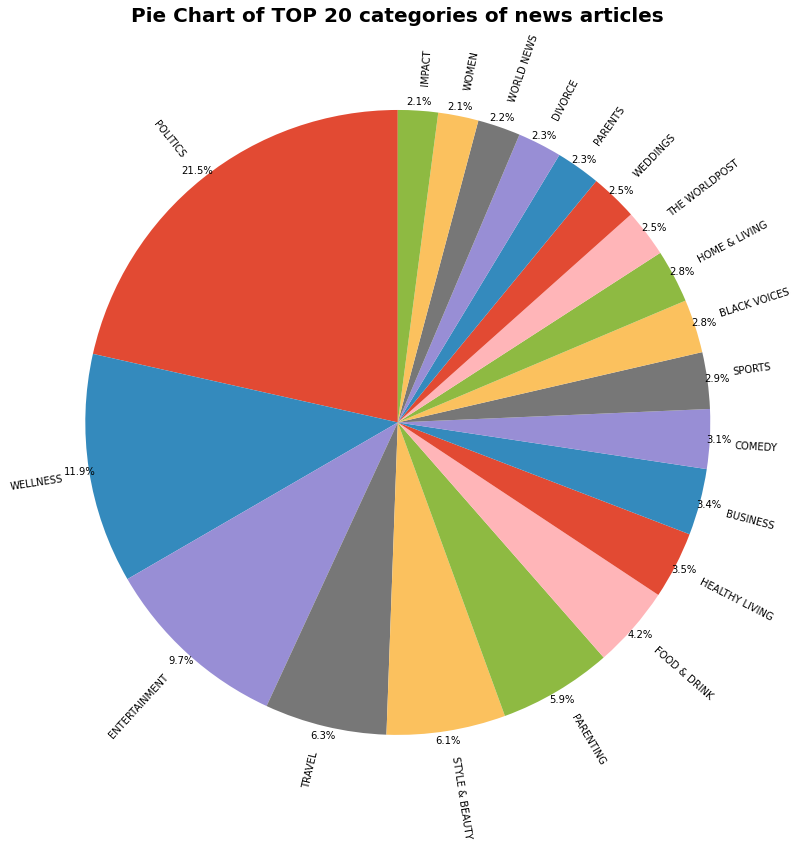

In [46]:
# plot the pie chart of top 20 categories of news articles
fig = plt.figure(figsize=(12,12))
A = plt.pie(cat_df['numcat'][:20],
            labels=cat_df['news_classes'][:20],
            autopct='%1.1f%%',
            startangle=90,
            labeldistance=1.08,
            pctdistance=1.03,
            rotatelabels=45
            )

plt.title("Pie Chart of TOP 20 categories of news articles", size=20, weight='bold')
plt.show()

### 1.2.3 Wordclouds of categories and news articles

- Wordcloud of categories in out dataframe
- Wordcloud of new articles in each of the categories

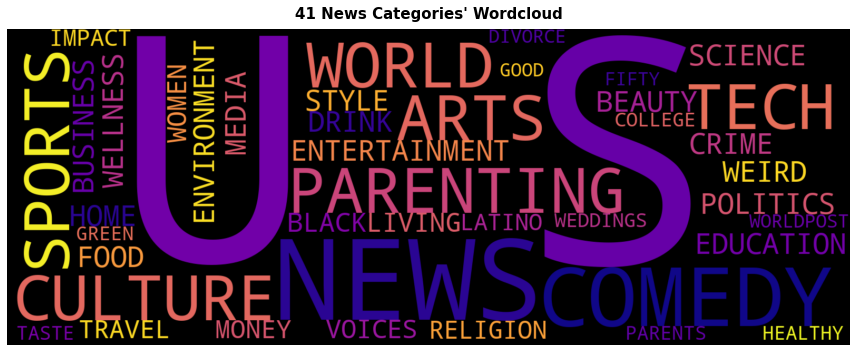

In [48]:
# wordcloud of categories of news articles in our dataset
# Combine all the categories into a single string
categories_text = ' '.join(new_df.category)
words = categories_text.split()
word_counts = Counter(words)
unique_words = list(word_counts.keys())

# Generate the wordcloud
plt.figure(figsize=(12, 12))
wc = WordCloud(max_words=1000,
               min_font_size=10,
               height=600,
               width=1600,
               background_color='black',
               contour_color='black',
               colormap='plasma',
               stopwords=STOPWORDS).generate(' '.join(unique_words))

plt.title("41 News Categories' Wordcloud", size=15, weight='bold')
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()

In [52]:
# create new dataframe of category and length of each news articles in that category
ndf = new_df.copy()
ndf['len_news'] = ndf['short_description'].map(lambda x: len(x))
ndf.drop('len_news', inplace=True, axis=1)

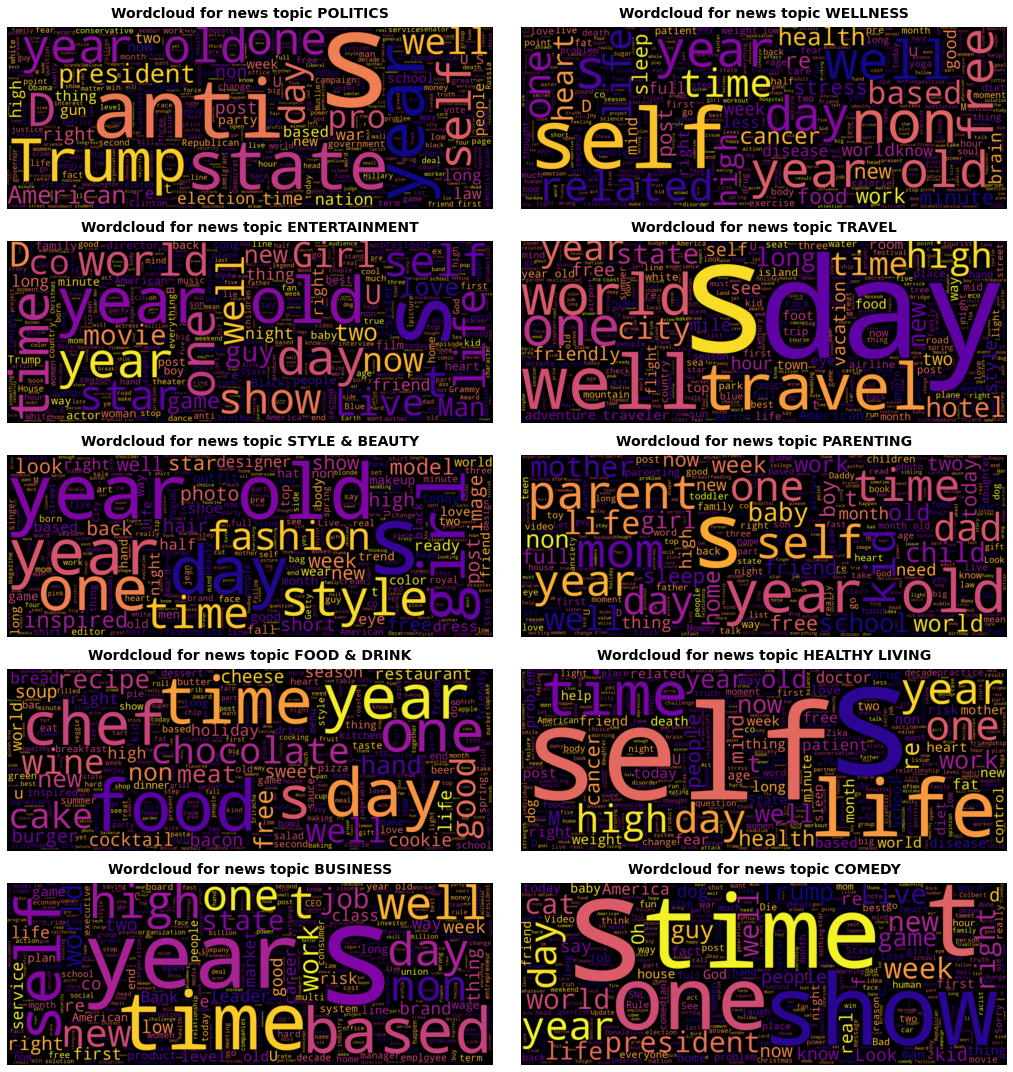

In [57]:
# list of top 10 categories in our dataset
categories = cat_df['news_classes'][:10].to_list()

# list of news articles of each top 10 categories list
articles_list = []

for i in categories:
    cat_ndf = ndf[ndf['category'] == i]
    cat_text = ' '.join(cat_ndf['short_description'].values.tolist())  # Combine all the news articles into a single string
    words = cat_text.split()
    word_counts = Counter(words)
    unique_words = list(word_counts.keys())
    articles_list.append(unique_words)

# create a wordcloud instance
wc1 = WordCloud(max_words=1000, 
               min_font_size=10,
               height=600,
               width=1600,
               background_color='black',
               contour_color='black',
               colormap='plasma',
               stopwords=STOPWORDS)

# plot the figure of 10 wordclouds from our dataset
plt.figure(figsize=(15, 15))

for idx, j in enumerate(categories):
    plt.subplot(5, 2, idx+1)
    cloud = wc1.generate(' '.join(articles_list[idx]))
    plt.imshow(cloud, interpolation="bilinear")
    plt.title(f"Wordcloud for news topic {j}")
    plt.axis('off')

plt.tight_layout()
plt.show()


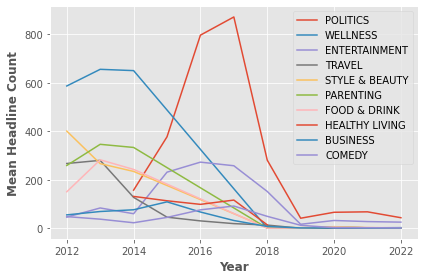

In [58]:
popular_categories = cat_df['news_classes'][:10].to_list()
ndf = df[df['category'].isin(popular_categories)]

# Group the dataframe by category, year, and month to get the count of headlines for each month
ndf['year'] = ndf['date'].dt.year
ndf['month'] = ndf['date'].dt.month

fig, ax = plt.subplots()

# Iterate over the categories
for category in popular_categories:
    # Group the data by category, year, and month and calculate the mean counts for each year
    yearly_counts = ndf[ndf['category'] == category].groupby(['year', 'month']).size().groupby('year').mean()
    
    # Plot the mean yearly counts
    ax.plot(yearly_counts.index, yearly_counts.values, label=category)

# Set the axis labels and legend
ax.set_xlabel('Year')
ax.set_ylabel('Mean Headline Count')
ax.legend()

# Show the plot
plt.show()

## Bозможно хедлайны с годом выборов ковид и др важны даты

В 2016 году состоялись выборы в Америке,где президентом был выбран Трамп

## 1.3 Text-data Preprocessing 

<a id="tdp"></a>


In [11]:
# clean the text data using regex and data cleaning function
def preprocess(text):
    text = text.lower() 
    text=text.strip()  
    text= re.sub(r'%', ' percent ', text)
    text=re.sub('\$', ' dollar ', text)
    text=re.compile('<.*?>').sub(' ', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)
    
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text=re.sub(r'[^\w\s]', ' ', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text)
    text = re.sub('\s+', ' ', text)  
    return text       

In [12]:
# removal of English particles and prepositions.
all_stopwords = stopwords.words('english')
def delete_stop_words(string):
    text_tokens = word_tokenize(string)
    tokens_without_sw = [word for word in text_tokens if not word in all_stopwords]
    filtered_sentence = (" ").join(tokens_without_sw)
    return filtered_sentence

In [65]:
ndf['short_description'] = df['short_description'].astype("string")
ndf.drop(columns=['link', 'headline', 'authors'], inplace=True)
ndf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112312 entries, 2 to 180727
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   category           112312 non-null  object        
 1   short_description  112312 non-null  string        
 2   date               112312 non-null  datetime64[ns]
 3   year               112312 non-null  int64         
 4   month              112312 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1), string(1)
memory usage: 5.1+ MB


In [66]:
# Preprocess the text
nlp = spacy.load('en_core_web_lg')

ndf['description_processed'] = ndf['short_description'].apply(preprocess)
ndf['description_processed'] = ndf['description_processed'].apply(delete_stop_words)
ndf['description_processed'] = ndf['description_processed'].apply(lambda x:' '.join( [w for w in x.split() if len(w)>2]))
ndf['description_processed'] = ndf['description_processed'].apply(lambda x: " ".join([token.lemma_ for token in nlp(x)]))
ndf.to_csv('df_processed.csv')
ndf.head()

,category,short_description,date,year,month,description_processed
2,COMEDY,"""Until you have a dog you don't understand wha...",2022-09-23,2022,9,dog understand could eaten
3,PARENTING,"""Accidentally put grown-up toothpaste on my to...",2022-09-23,2022,9,accidentally put grown toothpaste toddler toot...
20,ENTERTAINMENT,"For the past 18 months, Hollywood has effectiv...",2022-09-20,2022,9,past month hollywood effectively boycott globe...
21,POLITICS,President issues vow as tensions with China rise.,2022-09-19,2022,9,president issue vow tension china rise
24,POLITICS,An annual celebration took on a different feel...,2022-09-19,2022,9,annual celebration take different feel russia ...


In [7]:
ndf = pd.read_csv('/kaggle/working/df_processed.csv')
ndf = ndf.drop(columns=['Unnamed: 0'])

In [8]:
ndf = ndf.dropna()
ndf.reset_index(inplace=True, drop=True)
ndf

,category,short_description,date,year,month,description_processed
0,COMEDY,"""Until you have a dog you don't understand wha...",2022-09-23,2022,9,dog understand could eaten
1,PARENTING,"""Accidentally put grown-up toothpaste on my to...",2022-09-23,2022,9,accidentally put grown toothpaste toddler toot...
2,ENTERTAINMENT,"For the past 18 months, Hollywood has effectiv...",2022-09-20,2022,9,past month hollywood effectively boycott globe...
3,POLITICS,President issues vow as tensions with China rise.,2022-09-19,2022,9,president issue vow tension china rise
4,POLITICS,An annual celebration took on a different feel...,2022-09-19,2022,9,annual celebration take different feel russia ...
...,...,...,...,...,...,...
112109,BUSINESS,"After 30 years, ""People Greeters"" will no long...",2012-01-28,2012,1,year people greeter long welcome walmart custo...
112110,BUSINESS,"For decades, as crises have assailed developin...",2012-01-28,2012,1,decade crisis assail develop country indonesia...
112111,BUSINESS,"""Analysts at Adobe combined historical purchas...",2012-01-28,2012,1,analyst adobe combine historical purchase upgr...
112112,ENTERTAINMENT,Representation of the collective diaspora has ...,2012-01-28,2012,1,representation collective diaspora always thwa...


# 2. Modelling

<a id="mod"></a>

In [76]:
# Tokenize the preprocessed documents
tokenized_docs = [list(simple_tokenize(doc)) for doc in ndf['description_processed']]
# Create a dictionary and corpus
dictionary = Dictionary(tokenized_docs)
# Filter out extreme cases
dictionary.filter_extremes(no_below=5, no_above=0.5)
corpus = [dictionary.doc2bow(doc) for doc in tokenized_docs]

## Baseline LDA model

<a id="base"></a>

This serves as the baseline model.

In [73]:
NUM_TOPICS = 10

In [78]:
start_time = time.time()
# Train the LDA model
lda_model = LdaMulticore(corpus=corpus,
                         id2word=dictionary,
                         num_topics=NUM_TOPICS,
                         passes=10,
                         workers=4, 
                         random_state = 42)
# Print the topics
#for idx, topic in lda_model.print_topics(-1):
#    print('Topic: {} \nWords: {}\n'.format(idx, topic))
print("--- %s seconds ---" % (time.time() - start_time))

--- 418.8461184501648 seconds ---


In [79]:
# Compute coherence score
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.41497803774098346


## Investigation on hyperparameters tunning for LDA

<a id="param"></a>

In [21]:
# Create a dictionary and corpus
id2word = Dictionary(tokenized_docs)
# Filter out extreme cases
id2word.filter_extremes(no_below=5, no_above=0.5)
corpus = [id2word.doc2bow(doc) for doc in tokenized_docs]

In [30]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_docs, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [ ]:
grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 5
max_topics = 20
step_size = 5
topics_range = range(min_topics, max_topics+1, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

# Validation sets
num_of_docs = len(corpus)
corpus_sets = [corpus]

corpus_title = ['100% Corpus']

model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=(len(beta)*len(alpha)*len(topics_range)*len(corpus_title)))
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results1.csv', index=False)
    pbar.close()

In [26]:
pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
model_results_df = pd.DataFrame(model_results)
model_results_df

,Validation_Set,Topics,Alpha,Beta,Coherence
0,50% Corpus,5,0.01,0.01,0.254184
1,50% Corpus,5,0.01,0.31,0.305936
2,50% Corpus,5,0.01,0.61,0.342916
3,50% Corpus,5,0.01,0.91,0.416779
4,50% Corpus,5,0.01,symmetric,0.248588
...,...,...,...,...,...
86,50% Corpus,15,asymmetric,0.31,0.280651
87,50% Corpus,15,asymmetric,0.61,0.307287
88,50% Corpus,15,asymmetric,0.91,0.325096
89,50% Corpus,15,asymmetric,symmetric,0.281510


In [38]:
grouped_df

,Alpha,Coherence
0,0.01,0.329825
1,0.31,0.306787
2,0.61,0.318740
3,0.91,0.321802


Visualization of results for hyperparameters tunning

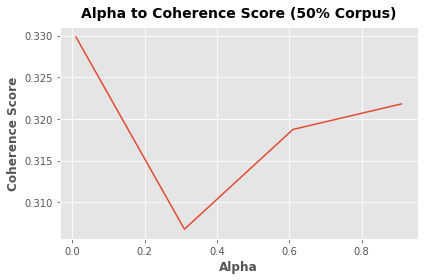

In [37]:
model_results_df = pd.read_csv('/kaggle/working/lda_tuning_results.csv')
# Filter the data for a specific validation set (e.g., '75% Corpus')
validation_set = '50% Corpus'
filtered_df = model_results_df[model_results_df['Validation_Set'] == validation_set]
filtered_df = filtered_df[filtered_df['Beta']!= 'symmetric']
filtered_df = filtered_df[filtered_df['Beta']!= 'asymmetric']
filtered_df = filtered_df[filtered_df['Alpha']!= 'symmetric']
filtered_df = filtered_df[filtered_df['Alpha']!= 'asymmetric']
# Group the data by alpha and calculate the mean coherence score for each alpha value
grouped_df = filtered_df.groupby('Alpha')['Coherence'].mean().reset_index()

# Plot the results
plt.plot(grouped_df['Alpha'], grouped_df['Coherence'])
plt.xlabel('Alpha')
plt.ylabel('Coherence Score')
plt.title(f'Alpha to Coherence Score ({validation_set})')
plt.show()

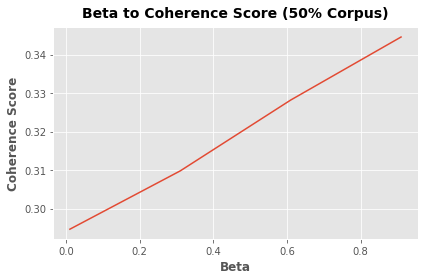

In [39]:

# Group the data by alpha and calculate the mean coherence score for each alpha value
grouped_df = filtered_df.groupby('Beta')['Coherence'].mean().reset_index()

# Plot the results
plt.plot(grouped_df['Beta'], grouped_df['Coherence'])
plt.xlabel('Beta')
plt.ylabel('Coherence Score')
plt.title(f'Beta to Coherence Score ({validation_set})')
plt.show()

3 best coherence results:

In [38]:
model_results_df = pd.read_csv('/kaggle/working/lda_tuning_results.csv')
model_results_df['Coherence'].nlargest(3)

3     0.416779
63    0.386669
53    0.380722
Name: Coherence, dtype: float64

In [40]:
model_results_df[model_results_df['Coherence']>0.35]

,Validation_Set,Topics,Alpha,Beta,Coherence
3,50% Corpus,5,0.01,0.9099999999999999,0.416779
23,50% Corpus,5,symmetric,0.9099999999999999,0.352512
33,50% Corpus,10,0.01,0.9099999999999999,0.354804
52,50% Corpus,10,symmetric,0.61,0.355410
53,50% Corpus,10,symmetric,0.9099999999999999,0.380722
63,50% Corpus,15,0.01,0.9099999999999999,0.386669
78,50% Corpus,15,0.9099999999999999,0.9099999999999999,0.363081


## LDA 2 model

<a id="final"></a>

In [80]:
# Create a dictionary and corpus
id2word = Dictionary(tokenized_docs)
# Filter out extreme cases
id2word.filter_extremes(no_below=5, no_above=0.5)
corpus = [id2word.doc2bow(doc) for doc in tokenized_docs]

In [69]:
NUM_TOPICS = 10

In [81]:
start_time = time.time()
# Train the LDA model
lda_model = LdaMulticore(corpus=corpus,
                         id2word=id2word, 
                         num_topics=NUM_TOPICS,
                         random_state=42,
                         passes=10,
                         workers=4,
                         alpha = 0.01,
                         eta=0.99)

print("--- %s seconds ---" % (time.time() - start_time))

--- 496.3633415699005 seconds ---


In [86]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}\n'.format(idx, topic))

Topic: 0 
Words: 0.015*"show" + 0.012*"night" + 0.012*"late" + 0.012*"week" + 0.010*"new" + 0.007*"host" + 0.006*"music" + 0.006*"last" + 0.006*"news" + 0.006*"first"

Topic: 1 
Words: 0.014*"life" + 0.010*"make" + 0.008*"people" + 0.008*"way" + 0.007*"one" + 0.007*"need" + 0.007*"change" + 0.006*"well" + 0.006*"time" + 0.006*"take"

Topic: 2 
Words: 0.031*"year" + 0.018*"new" + 0.016*"study" + 0.011*"old" + 0.008*"cancer" + 0.008*"month" + 0.008*"find" + 0.007*"researcher" + 0.007*"percent" + 0.007*"report"

Topic: 3 
Words: 0.028*"trump" + 0.022*"say" + 0.021*"president" + 0.011*"donald" + 0.010*"house" + 0.008*"campaign" + 0.008*"republican" + 0.008*"obama" + 0.008*"white" + 0.007*"former"

Topic: 4 
Words: 0.013*"man" + 0.012*"film" + 0.011*"star" + 0.011*"woman" + 0.011*"movie" + 0.007*"game" + 0.007*"video" + 0.007*"play" + 0.006*"name" + 0.005*"one"

Topic: 5 
Words: 0.015*"get" + 0.014*"time" + 0.012*"like" + 0.012*"one" + 0.012*"day" + 0.011*"know" + 0.009*"thing" + 0.009*"say

In [87]:
topics = lda_model.show_topics(num_topics=10, num_words=10)

# Define the file path
file_path = 'lda_topics.txt'

# Open the file in write mode and write the topics
with open(file_path, 'w') as file:
    for topic in topics:
        topic_id, words = topic
        file.write(f"Topic ID: {topic_id}\n")
        file.write(f"Words: {words}\n")
        file.write('\n')


In [82]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_docs, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.43988786291897986


# 3. Investigation on LDA results
<a id="invest"></a>


In [96]:
coherence_ldas = coherence_model_lda.get_coherence_per_topic()
print('\nCoherence Score: ', coherence_ldas)


Coherence Score:  [0.40482116173654986, 0.4652168693117022, 0.4548741244472546, 0.6750874123651073, 0.38103490223886977, 0.39961385186067655, 0.33135995751889985, 0.5186087981600502, 0.2990224227875739, 0.46923912876311435]


In [103]:
coherence_ldas.sort(reverse=True)
coherence_ldas[:5]

[0.6750874123651073,
 0.5186087981600502,
 0.46923912876311435,
 0.4652168693117022,
 0.4548741244472546]

/opt/conda/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/conda/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


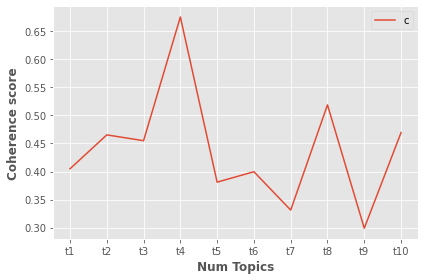

In [84]:
topicsname=[]

for i in range(1,lda_model.num_topics +1):
    topicsname.append("t{0}".format(i))
topicsname

plt.plot(topicsname,coherence_ldas)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [88]:
# Visualize the topics
pyLDAvis.enable_notebook()

# feed the LDA model into the pyLDAvis instance
lda_viz = gensim.prepare(lda_model, corpus, id2word)
pyLDAvis.save_html(lda_viz, 'ldavis_tuned_'+ str(10) +'.html')
lda_viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.077739 -0.182952       1        1  20.295522
5     -0.147805 -0.084924       2        1  19.439692
9      0.149043 -0.095895       3        1  10.600677
3      0.127995  0.000196       4        1   9.463769
6     -0.163832  0.071034       5        1   8.740999
8     -0.110129  0.053790       6        1   8.588484
2      0.072885 -0.049616       7        1   7.257323
0      0.032101  0.169835       8        1   6.005997
7      0.085068 -0.011836       9        1   4.869337
4      0.032412  0.130369      10        1   4.738202, topic_info=          Term         Freq        Total Category  logprob  loglift
220      trump  3558.000000  3558.000000  Default  30.0000  30.0000
139       year  6005.000000  6005.000000  Default  29.0000  29.0000
33   president  2972.000000  2972.000000  Default  28.0000  28.0000
52         say  7265.000000  7265.000000  Default  27.0000  27.0000
277       life  4465.000000  4465.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
327        see   249.042874  3617.847334  Topic10  -5.5041   0.3735
52         say   273.399234  7265.517611  Topic10  -5.4108  -0.2304
169       well   232.689766  4065.976489  Topic10  -5.5721   0.1888
73         new   203.068310  5890.816275  Topic10  -5.7082  -0.3181
97        show   186.042719  2531.111328  Topic10  -5.7958   0.4391

[659 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
355       1  0.007224  abortion
355       2  0.007224  abortion
355       3  0.946404  abortion
355       4  0.014449  abortion
355       5  0.007224  abortion
...     ...       ...       ...
252       6  0.008315   youtube
252       7  0.016631   youtube
252       8  0.191256   youtube
252       9  0.008315   youtube
252      10  0.723446   youtube

[5500 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 6, 10, 4, 7, 9, 3, 1, 8, 5])

### Graphical representation
<a id="graph"></a>

In [144]:
newdf = ndf.copy()
#newdf.drop(columns=['link', 'authors'], inplace=True, axis=1)
newdf['category'].unique()

array(['COMEDY', 'PARENTING', 'ENTERTAINMENT', 'POLITICS', 'WELLNESS',
       'BUSINESS', 'STYLE & BEAUTY', 'FOOD & DRINK', 'TRAVEL',
       'HEALTHY LIVING'], dtype=object)

In [153]:
newdf = newdf.sort_values('date')
newdf['year'] = newdf['date'].dt.year
newdf = newdf[(newdf['year'] >= 2019)&(newdf['year'] <= 2021)]
newdf.head()

,category,short_description,date,year,month,description_processed
4401,COMEDY,His routine ranged from commentary on Louis C....,2019-01-01,2019,1,routine range commentary louis girlfriend aria...
4400,ENTERTAINMENT,"A Massachusetts judge denied the ""House of Car...",2019-01-01,2019,1,massachusetts judge deny house cards star requ...
4398,ENTERTAINMENT,"Okerlund was given his ""Mean"" Gene nickname by...",2019-01-02,2019,1,okerlund give mean gene nickname jesse body ve...
4399,ENTERTAINMENT,"""So convenient.""",2019-01-02,2019,1,convenient
4396,ENTERTAINMENT,"""The Good Place"" star tweeted that she'd be tu...",2019-01-02,2019,1,good place star tweet turn body positivity ins...


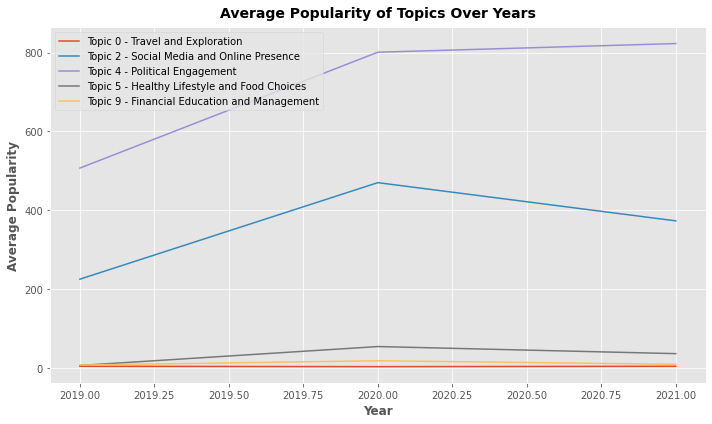

In [154]:
# Define the topics and their corresponding categories
topics = ['Topic 0 - Travel and Exploration', 'Topic 2 - Social Media and Online Presence',
          'Topic 4 - Political Engagement', 'Topic 5 - Healthy Lifestyle and Food Choices',
          'Topic 9 - Financial Education and Management']
categories = [['TRAVEL'], ['ENTERTAINMENT', 'STYLE & BEAUTY'], ['POLITICS'],
              ['FOOD & DRINK', 'HEALTHY LIVING'], ['BUSINESS']]

# Calculate the average popularity for each topic over seasons
average_counts = []
years = []
for i in range(len(topics)):
    category_list = categories[i]
    yearly_counts = newdf[newdf['category'].isin(category_list)].groupby(['year']).size().groupby('year').mean()
    average_counts.append(list(yearly_counts))
    years.extend(yearly_counts.index.tolist())

years = sorted(set(years))

# Plot the average popularity of each topic over seasons
plt.figure(figsize=(10, 6))
for i in range(len(topics)):
    topic_counts = average_counts[i]
    topic_counts_extended = [topic_counts[year - years[0]] if (year - years[0]) < len(topic_counts) else None for year in years]
    plt.plot(years, topic_counts_extended, label=topics[i])

# Set plot properties
plt.title('Average Popularity of Topics Over Years')
plt.xlabel('Year')
plt.ylabel('Average Popularity')
#plt.xticks(range(len(years)), years, rotation='vertical')
plt.legend()

plt.tight_layout()
plt.show()


# BERTopic model
<a id="bert"></a>

In [ ]:
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine')
hdbscan_model = HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom', prediction_data=True)
vectorizer_model = CountVectorizer(stop_words="english")
ctfidf_model = ClassTfidfTransformer()

In [ ]:
#filtered_text = ndf['description_processed'].tolist()
filtered_text = []
lemmatizer = WordNetLemmatizer()

for w in ndf['short_description']:
    w = preprocess(w)
    w = delete_stop_words(w)
    filtered_text.append(lemmatizer.lemmatize(w))
print(filtered_text[:1])

In [ ]:
representation_model = MaximalMarginalRelevance(diversity=0.5)
topic_model = BERTopic(
  embedding_model=embedding_model,    # Step 1 - Extract embeddings
  umap_model=umap_model,              # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model,        # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model,  # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model,          # Step 5 - Extract topic words
  representation_model=representation_model,
  nr_topics=10                        
)

In [ ]:
start_time = time.time()
topics, probabilities = topic_model.fit_transform(filtered_text)
print("--- %s seconds ---" % (time.time() - start_time))

In [45]:
topic_model.save('BERTopic_model')

## Getting topics from BERTopic model and evaluation
<a id="berteval"></a>

In [ ]:
topics_words = topic_model.get_topics()
with open('bert_topics_final.txt', 'w') as f:
    for topic_id, topic_words in topics_words.items():
        topic_words = [word for word, _ in topic_words]
        f.write(f"Topic: {topic_id}\n")
        f.write(f"Words: {', '.join(topic_words)}\n\n")

In [ ]:
documents = pd.DataFrame({"Document": filtered_text,
                          "ID": range(len(filtered_text)),
                          "Topic": topics})
documents_per_topic = documents.groupby(['Topic'], as_index=False).agg({'Document': ' '.join})
cleaned_docs = topic_model._preprocess_text(documents_per_topic.Document.values)

In [44]:
# Extract vectorizer and analyzer from BERTopic
vectorizer = topic_model.vectorizer_model
analyzer = vectorizer.build_analyzer()

# Extract features for Topic Coherence evaluation
words = vectorizer.get_feature_names()

# Create a generator expression for tokens
tokens = [analyzer(doc) for doc in cleaned_docs]
dictionary = Dictionary(tokens)
corpus = [dictionary.doc2bow(token) for token in tokens]
topic_words = [[words for words, _ in topic_model.get_topic(topic)] for topic in range(len(set(topics))-1)]

# Evaluate
coherence_model = CoherenceModel(topics=topic_words,
                                 texts=tokens,
                                 corpus=corpus,
                                 dictionary=dictionary,
                                 coherence='c_v')
coherence = coherence_model.get_coherence()

print(f"Coherence Score: {coherence}")

Coherence Score: 0.5907011235974472


## Visualizations
<a id="viz"></a>

In [52]:
# Visualize the topics
topic_model.visualize_topics()


In [54]:
topic_model.visualize_heatmap()

In [55]:
topic_model.visualize_barchart()

In [105]:
topic_model.visualize_hierarchy()

In [131]:
timestamps = ndf['date'].to_list()
topics_over_time = topic_model.topics_over_time(filtered_text, timestamps, nr_bins=20)

In [136]:
topic_model.visualize_topics_over_time(topics_over_time, topics=[1,2,3,4,5,6,7,8])

In [138]:
topic_model.visualize_topics_over_time(topics_over_time, top_n_topics = 5)